In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from scipy.special import legendre

In [3]:
sns.set_style('ticks')
sns.set_context('talk')

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
data_dir = '/home/julia/data/ict/'

## Smooth session

In [8]:
mouse='WEY'
day=0
df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mouse))
signal_series = df[(df['day']==day)]['gpmt']
reference_series = df[(df['day']==day)]['rpmt']
raw_signal = np.empty(0)
for trial in signal_series:
    raw_signal = np.append(raw_signal, trial)
    
raw_reference = np.empty(0)
for trial in reference_series:
    raw_reference = np.append(raw_reference, trial)

In [9]:
smooth_signal = gaussian_filter1d(raw_signal, sigma=100, output=np.float64)
smooth_reference = gaussian_filter1d(raw_reference, sigma=100, output=np.float64)

## Fit baseline

In [10]:
poly_1 = legendre(1)(np.linspace(-1,1,smooth_signal.shape[0]))
poly_2 = legendre(2)(np.linspace(-1,1,smooth_signal.shape[0]))
poly_3 = legendre(3)(np.linspace(-1,1,smooth_signal.shape[0]))
X = np.vstack((poly_1, poly_2, poly_3)).T

lin_signal = LinearRegression()
model_signal = lin_signal.fit(X, smooth_signal)
predict_signal = lin_signal.predict(X)

lin_reference = LinearRegression()
model_reference = lin_reference.fit(X, smooth_reference)
predict_reference = lin_reference.predict(X)

In [11]:
model_signal.coef_

array([-0.00241969,  0.00080765, -0.00056718])

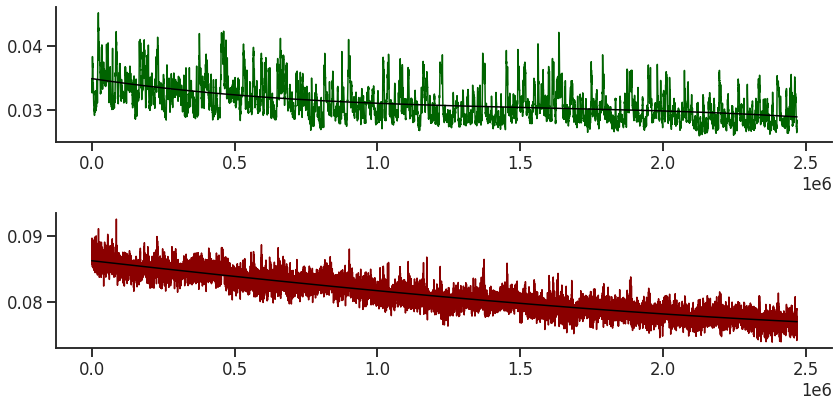

In [12]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax1.plot(smooth_signal,'darkgreen',linewidth=1.5)
ax1.plot(predict_signal,'black',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(smooth_reference,'darkred',linewidth=1.5)
ax2.plot(predict_reference,'black',linewidth=1.5)
plt.tight_layout()
sns.despine()

## Remove baseline and z-score

In [13]:
signal = smooth_signal - predict_signal 
reference = smooth_reference - predict_reference

In [14]:
z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

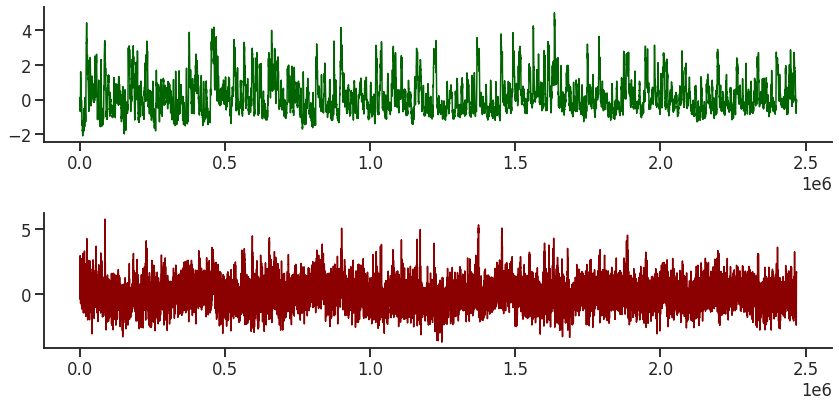

In [15]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax1.plot(z_signal,'darkgreen',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(z_reference,'darkred',linewidth=1.5)
plt.tight_layout()
sns.despine()

## Fit linear regression

In [16]:
lin = LinearRegression()
n = len(z_reference)
model = lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))
reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)
corr_signal = (z_signal - reference_fitted)

In [17]:
idx=np.arange(0,z_signal.shape[0],100)

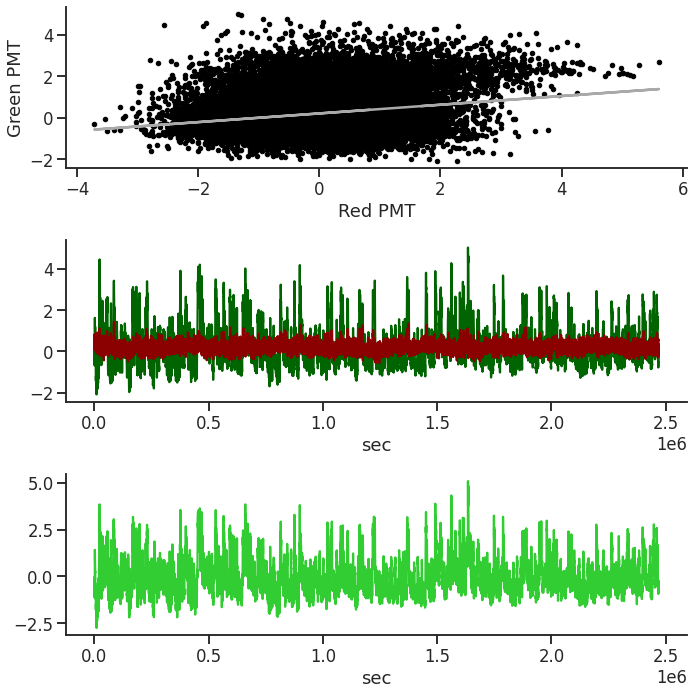

In [18]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
ax1.plot(z_reference[idx],z_signal[idx],'k.', linewidth=0)
ax1.plot(z_reference[idx],reference_fitted[idx], color='darkgrey', 
         linewidth=2.5)
ax1.set_xlabel('Red PMT')
ax1.set_ylabel('Green PMT')


ax2 = fig.add_subplot(312)
ax2.plot(z_signal,'darkgreen', label='Green PMT')
ax2.plot(reference_fitted,'darkred', label='Fitted Red PMT')
ax2.set_xlabel('sec')

ax3 = fig.add_subplot(313)
ax3.plot(corr_signal,'limegreen')
ax3.set_xlabel('sec')

plt.tight_layout()
sns.despine()

## Split into trials again

In [19]:
mouse='WEY'
day=0
df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mouse))
signal_series = df[(df['day']==day)]['gpmt']
reference_series = df[(df['day']==day)]['rpmt']
raw_signal = np.empty(0)
for trial in signal_series:
    raw_signal = np.append(raw_signal, trial)
    
raw_reference = np.empty(0)
for trial in reference_series:
    raw_reference = np.append(raw_reference, trial)

In [36]:
corr_series = []
idx = 0
for trial in signal_series:
    corr_series.append(corr_signal[idx:idx+trial.shape[0]])
    idx += trial.shape[0]
    

In [38]:
len(corr_series)

151

In [39]:
len(signal_series)

151

In [40]:
test_full = np.empty(0)
for trial in corr_series:
    test_full = np.append(test_full, trial)

In [41]:
np.all(test_full == corr_signal)

True